In [178]:
import pandas as pd
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip"
urllib.request.urlretrieve(url, "./fr.openfoodfacts.org.products.csv.zip")

('./fr.openfoodfacts.org.products.csv.zip',
 <http.client.HTTPMessage at 0x208bc152480>)

In [179]:
with zipfile.ZipFile("./fr.openfoodfacts.org.products.csv.zip", 'r') as zipRef:
    with zipRef.open('fr.openfoodfacts.org.products.csv') as file:
        data = pd.read_csv(file, sep="\t", low_memory=False)

In [180]:
varList = data.columns.tolist()
sizeData = data.shape[0]
print(varList)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_fr', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_fr', 'ingredients_text', 'allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr', 'serving_size', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_fr', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 

In [181]:
startNut = varList.index("energy_100g")
print(startNut)

63


In [182]:
size = data[data.duplicated()].shape[0]
if size == 0:
    print("No exact duplicated")
else:
    print(f"exact duplicated :{size}")
subset = ['code']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"exact duplicated with subset {subset} :{size}")
subset = ['product_name', 'creator', 'quantity']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")
subset = ['product_name', 'brands', 'quantity', 'categories', 'countries']
size = sizeSubset = data.dropna(subset=subset).duplicated(subset=subset).sum()
if size == 0:
    print(f"No possible duplicated with subset : {subset}")
else:
    print(f"Possible duplicated with subset {subset} :{size}")


No exact duplicated
No possible duplicated with subset : ['code']
Possible duplicated with subset ['product_name', 'creator', 'quantity'] :1939
Possible duplicated with subset ['product_name', 'brands', 'quantity', 'categories', 'countries'] :138


In [183]:
missingRate = data.iloc[:, :startNut].isnull().sum()/sizeData
print(missingRate.shape[0])
print(missingRate[missingRate >= 0.5])

63
generic_name                                 0.84
quantity                                     0.67
packaging                                    0.75
packaging_tags                               0.75
categories                                   0.74
categories_tags                              0.74
categories_fr                                0.74
origins                                      0.93
origins_tags                                 0.93
manufacturing_places                         0.89
manufacturing_places_tags                    0.89
labels                                       0.85
labels_tags                                  0.85
labels_fr                                    0.85
emb_codes                                    0.91
emb_codes_tags                               0.91
first_packaging_code_geo                     0.94
cities                                       1.00
cities_tags                                  0.94
purchase_places                              0.

In [184]:
missingRateNut = data.iloc[:, startNut:].isnull().sum()/sizeData
print(missingRateNut.shape[0])
print(missingRateNut[missingRateNut >= 0.5])

99
energy-from-fat_100g    1.00
butyric-acid_100g       1.00
caproic-acid_100g       1.00
caprylic-acid_100g      1.00
capric-acid_100g        1.00
                        ... 
cocoa_100g              1.00
chlorophyl_100g         1.00
carbon-footprint_100g   1.00
glycemic-index_100g     1.00
water-hardness_100g     1.00
Length: 88, dtype: float64


In [185]:
def prepareData(data, targetColumn, subsetDup):
    if targetColumn not in data.columns:
        raise ValueError(f"{targetColumn} is not in dataFrame.")

    dataCleaned = data.dropna(subset=[targetColumn])
    y = dataCleaned[targetColumn]
    X = dataCleaned.drop(columns=[targetColumn])

    columnsKeep = X.columns[X.isnull().mean() < 0.5]
    X = X[columnsKeep]
    
    subsetDup = [col for col in subsetDup if col in X.columns]
    
    if subsetDup:
        X = X.drop_duplicates(subset=subsetDup)
        y = y.loc[X.index]
    else:
        print("No target for subsetDup.")
    return X, y

on calcul consiste à faire la différence, pour 100 gr ou 100 mL de produit, entre les composantes négatives (sucres, sel, acides gras saturés) et positives (fibres, protéines, fruits, légumes, légumineuses, fruits à coques, huile de colza, de noix et d’olive) d'un aliment afin de lui attribuer une note
La categorie joue aussi un role les seuil differe

In [186]:
try:
    subsetDup = ['product_name', 'brands', 'quantity', 'categories', 'countries']
    XClean, y = prepareData(data, 'nutrition-score-fr_100g', subsetDup)

    print("Nb raws after clean :", len(XClean))
    print("Nb features:", XClean.shape[1])
    columnsX = XClean.columns.tolist()
    print("\n10 first features:")
    print(columnsX[:10])
    startNut = columnsX.index("energy_100g")
    print("\nFeatures nutritional:")
    print(columnsX[startNut : ])
    print("\nDistribution of the target variable:")
    print(y.value_counts(normalize=True))
    
    print("\nDescriptive statistics for some numeric columns:")
    numericColumns = [
    'energy_100g',
    'energy-from-fat_100g', 
    'fat_100g',
    'saturated-fat_100g', 
    'sugars_100g' ,
    'salt_100g', 
    'sodium_100g',
    'fiber_100g',
    'proteins_100g',
    'fruits-vegetables-nuts_100g',
    'nutrition-score-uk_100g'
    ]
    print(f'Features needed in Nutriscoring : {numericColumns}')
    numericColumns = [col for col in numericColumns if col in XClean.columns]
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(XClean[numericColumns].describe())

except Exception as e:
    print(f"Error : {e}")

Nb raws after clean : 205268
Nb features: 41

10 first features:
['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'brands', 'brands_tags']

Features nutritional:
['energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-uk_100g']

Distribution of the target variable:
nutrition-score-fr_100g
0.00     0.06
1.00     0.05
14.00    0.05
2.00     0.05
13.00    0.04
-1.00    0.04
11.00    0.04
12.00    0.04
3.00     0.04
15.00    0.03
10.00    0.03
20.00    0.03
16.00    0.03
21.00    0.03
9.00     0.03
4.00     0.03
-2.00    0.03
19.00    0.03
17.00    0.03
18.00    0.03
8.00     0.02
-3.00    0.02
-6.00    0.02
5.00     0.02
6.00     0.02
23.00    0.02
22.00    0.02
-4.00    0.02
7.00     0.02
24.00    0.02
-5.00   

In [187]:
def cleanOutliers(data, columns, lowerPercentile=0.01, upperPercentile=0.9999):
    dataClean = data.copy()
    for col in columns:
        if np.issubdtype(dataClean[col].dtype, np.number):
            lower = dataClean[col].quantile(lowerPercentile)
            upper = dataClean[col].quantile(upperPercentile)
            dataClean[col] = dataClean[col].clip(lower, upper)
        else:
            print(f"Column {col} not a number.")
    return dataClean

In [188]:
XClean = cleanOutliers(XClean, numericColumns)

In [189]:
def plotBoxplots(data, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.boxplot(x=data[col])
    plt.tight_layout()
    plt.show()

In [190]:
def plotHistograms(data, columns):
    plt.figure(figsize=(15, 5 * (len(columns) // 3 + 1)))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns) // 3 + 1, 3, i)
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

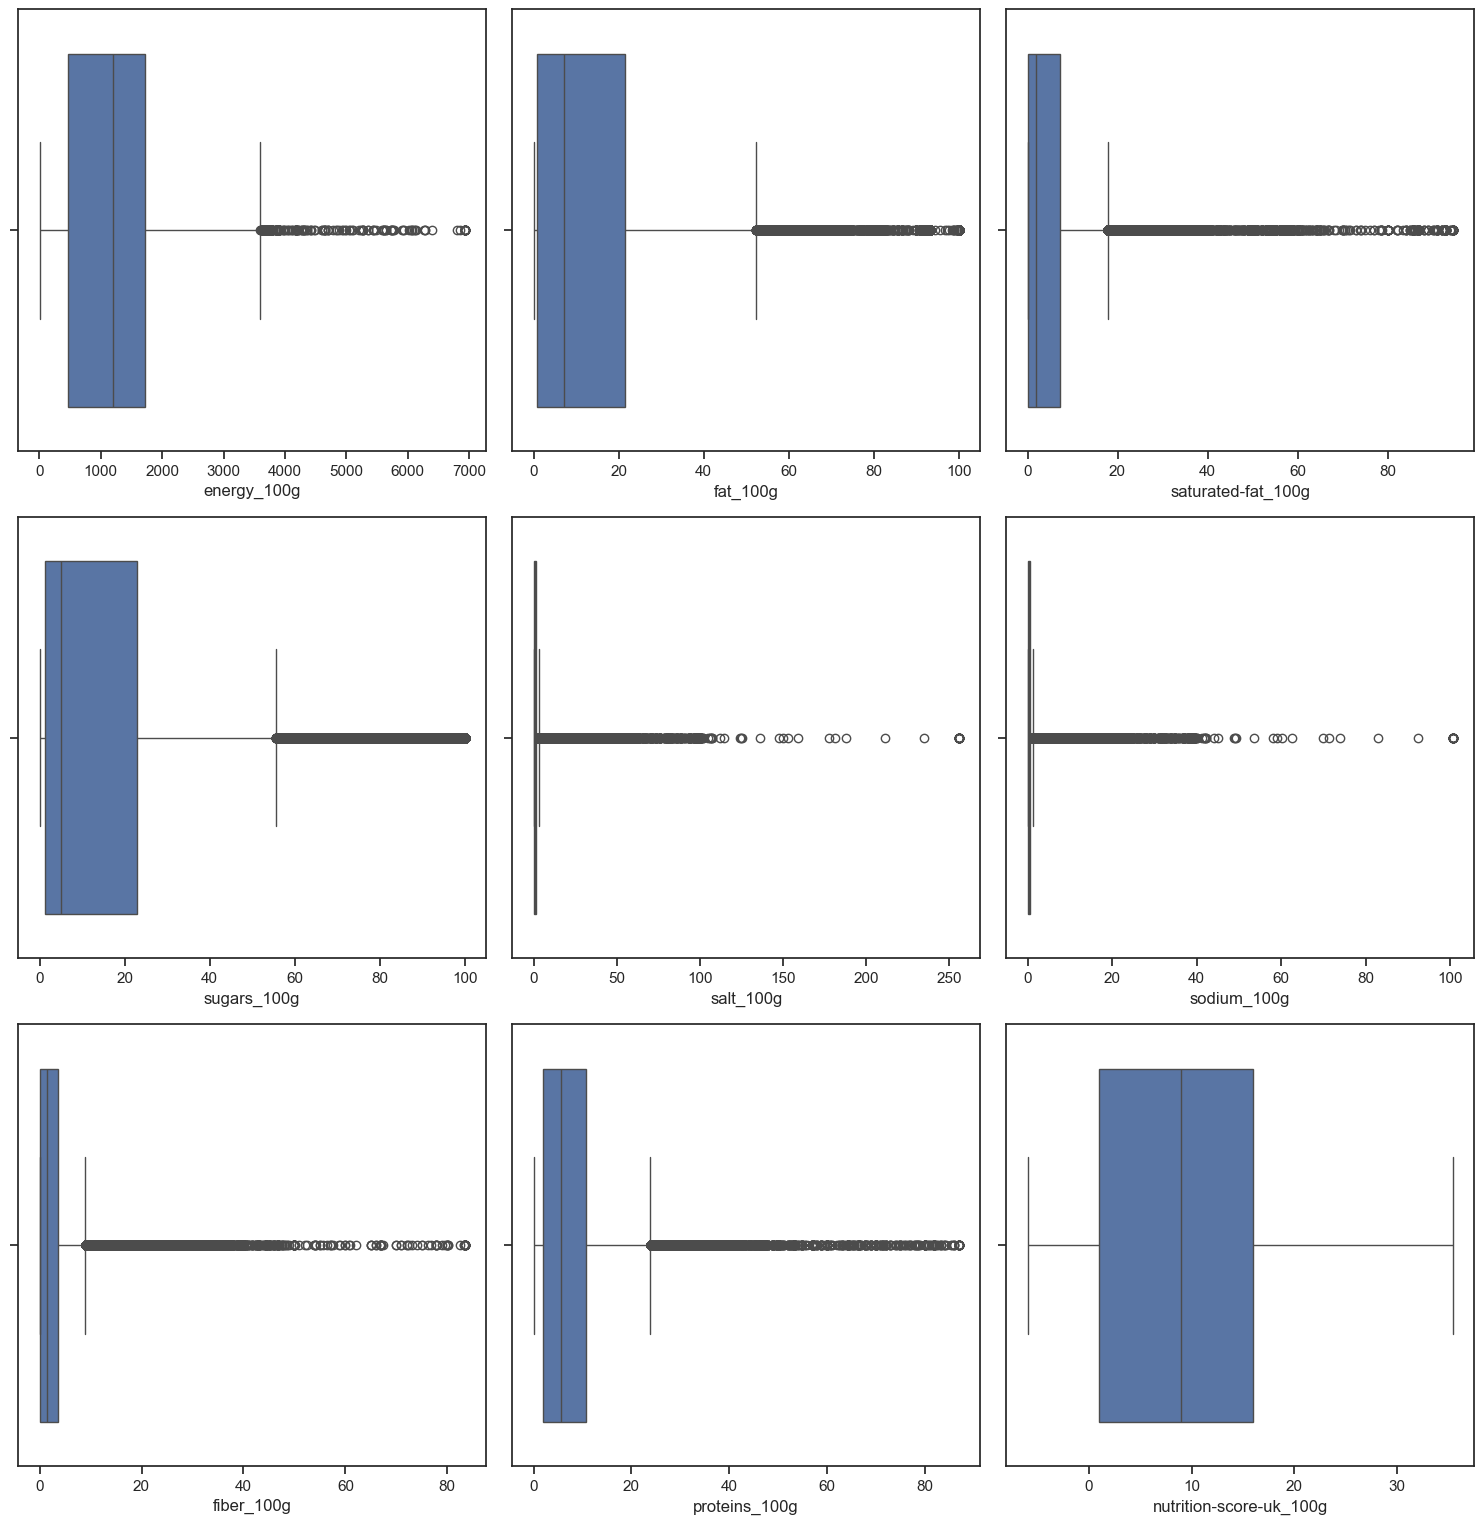

In [191]:
plotBoxplots(XClean, numericColumns)

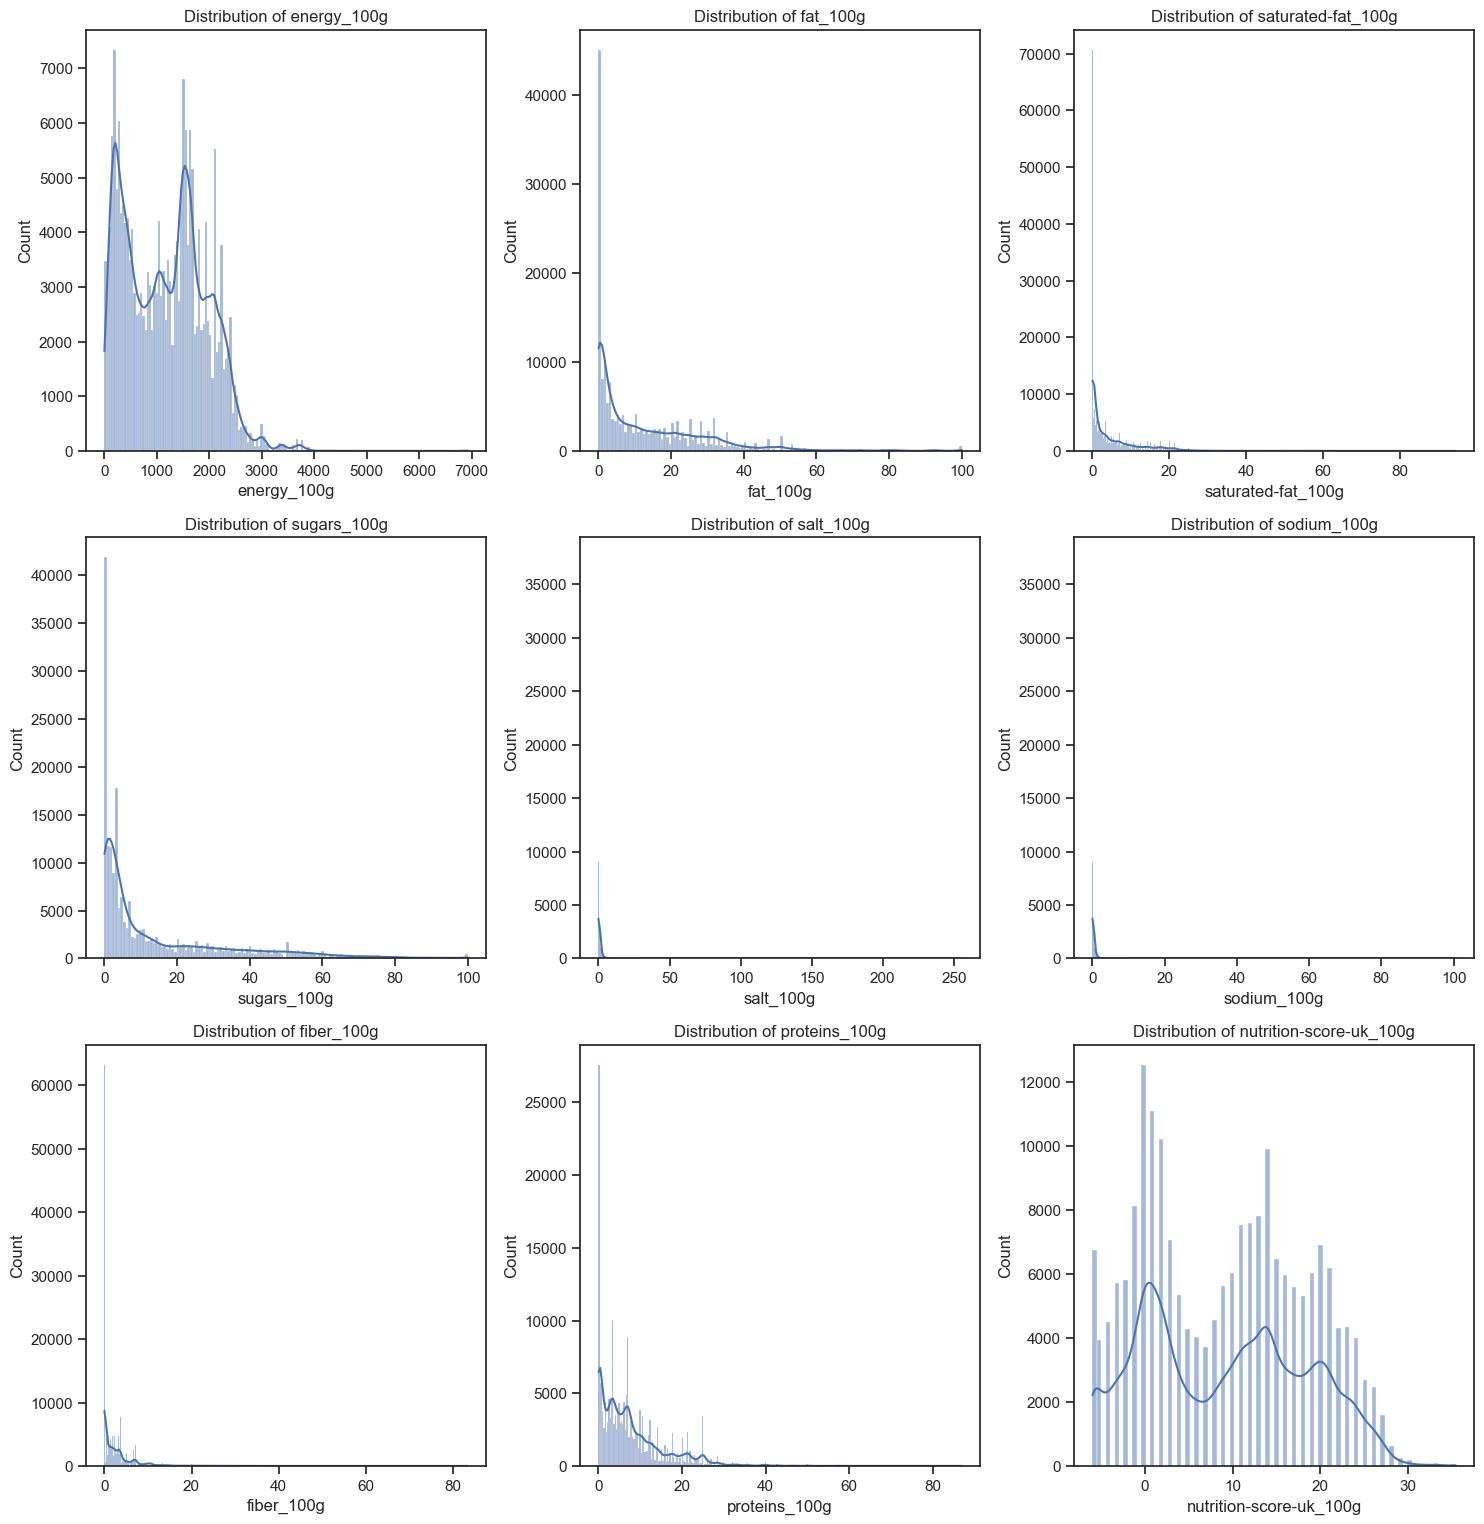

In [192]:
plotHistograms(XClean, numericColumns)

In [193]:
def checkConvert(value, minVal, maxVal, scale):
    if value < minVal or value > maxVal:
        converted_value = value / scale
        if minVal <= converted_value <= maxVal:
            return converted_value
    return value
            
def treatOutliers(data, thresholds):
    dataClean = data.copy()
    for col, (minVal, maxVal) in thresholds.items():
        if col in data.columns:
            if col != 'energy_100g':
                dataClean[col] = dataClean[col].apply(lambda x: checkConvert(x, minVal, maxVal, 1000))
            dataClean.loc[dataClean[col] < minVal, col] = minVal
            dataClean.loc[dataClean[col] > maxVal, col] = maxVal
    return dataClean

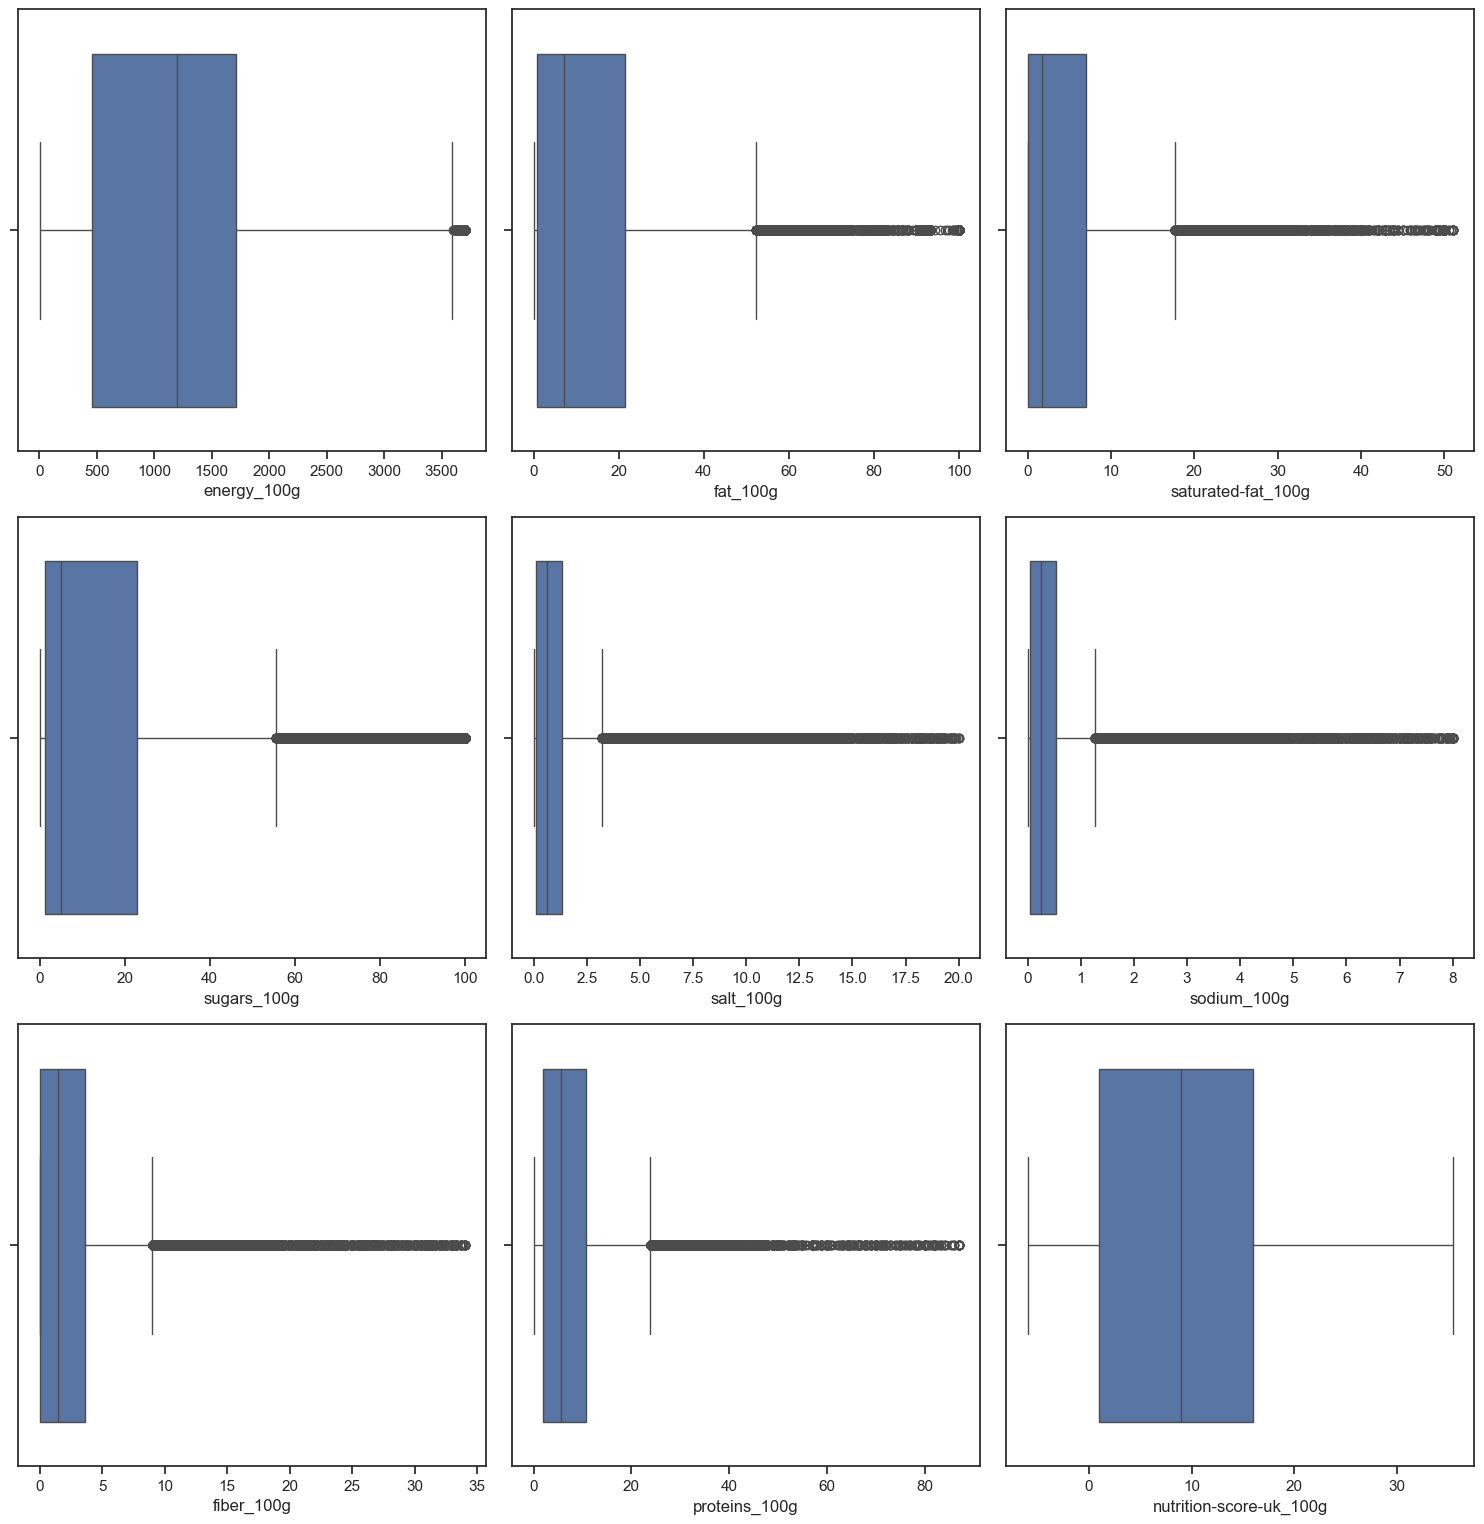

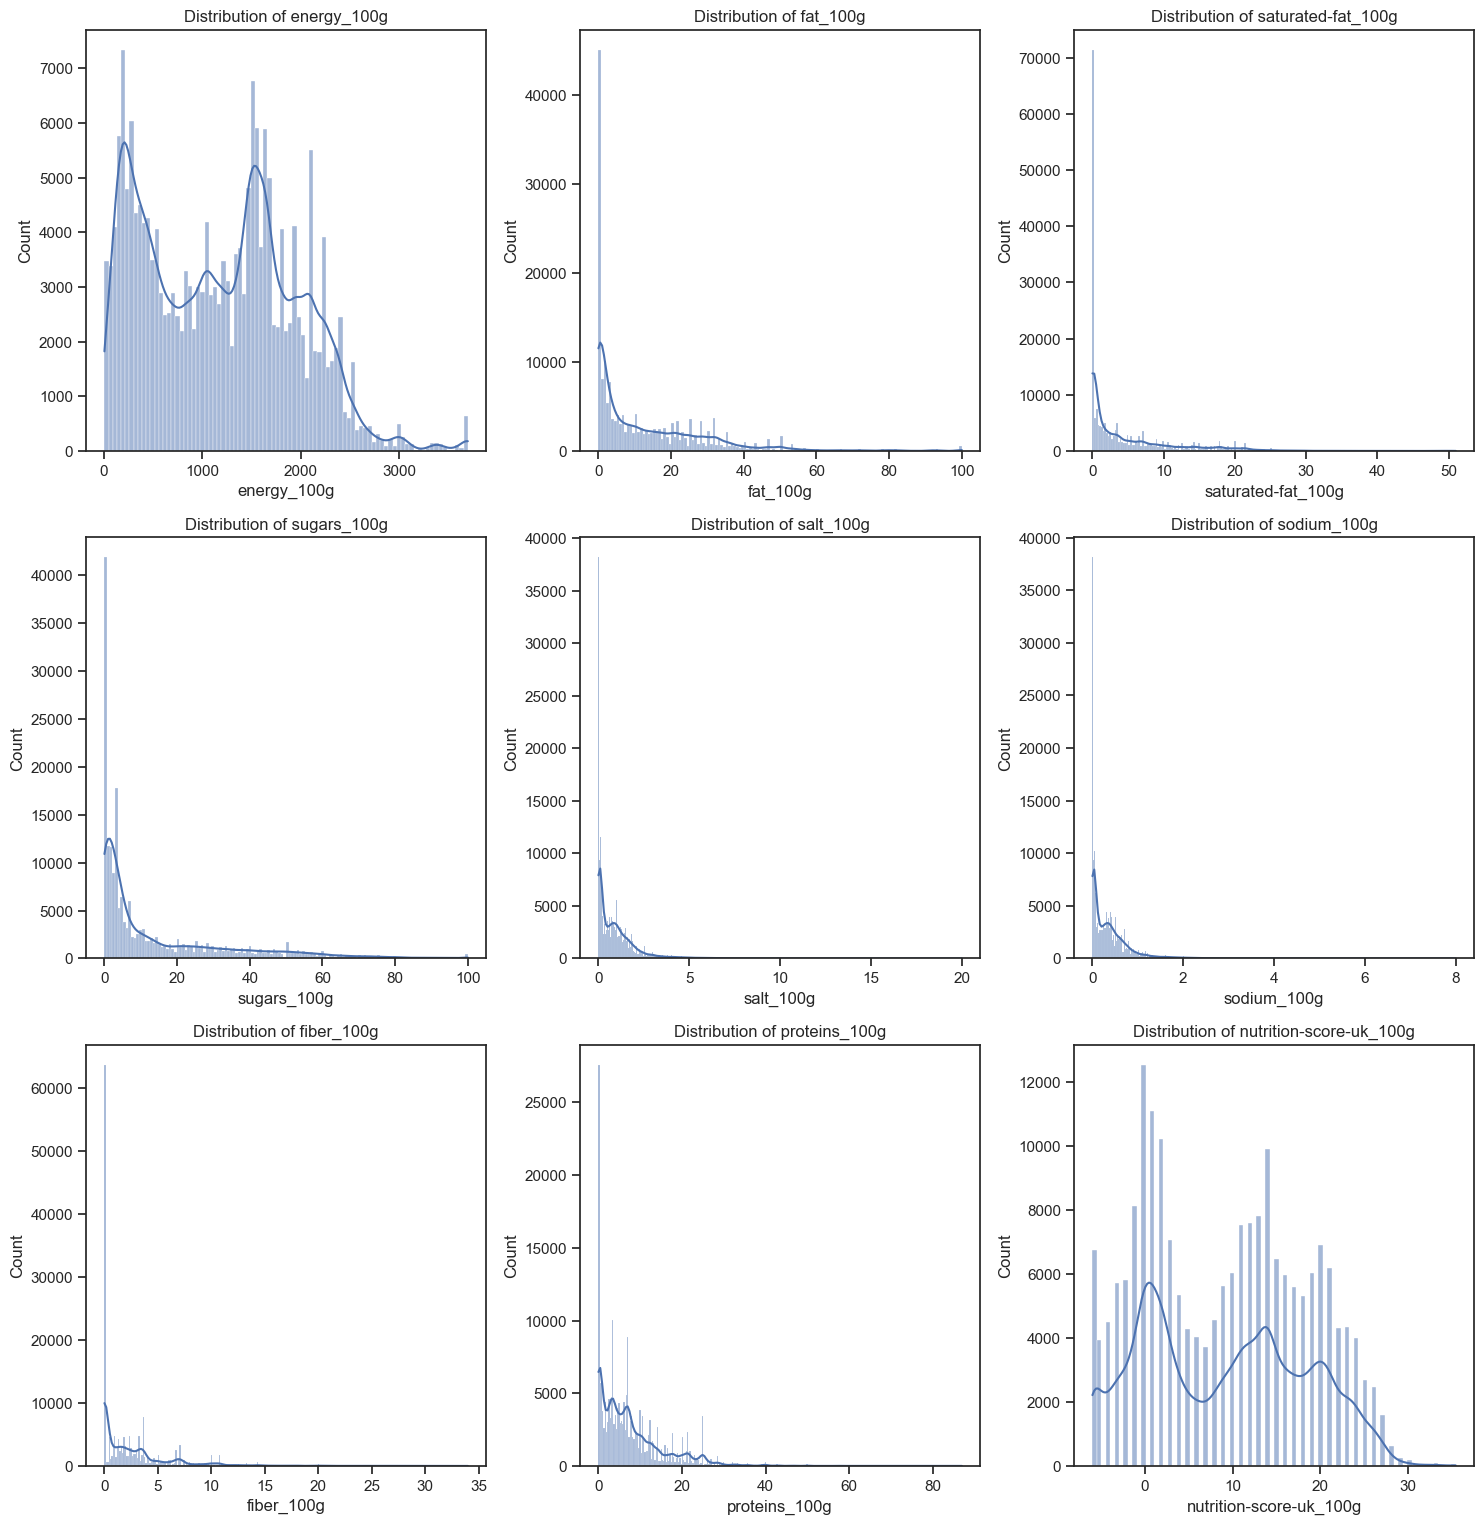

In [194]:
outlierThresholds = {
    'energy_100g': (0, 3699),
    'fat_100g': (0, 100),
    'saturated-fat_100g': (0, 51),
    'sugars_100g': (0, 100),
    'fiber_100g': (0, 34),
    'proteins_100g': (0, 90),
    'salt_100g': (0, 20),
    'sodium_100g': (0, 8)
}

XClean = treatOutliers(XClean, outlierThresholds)
plotBoxplots(XClean, numericColumns)
plotHistograms(XClean, numericColumns)

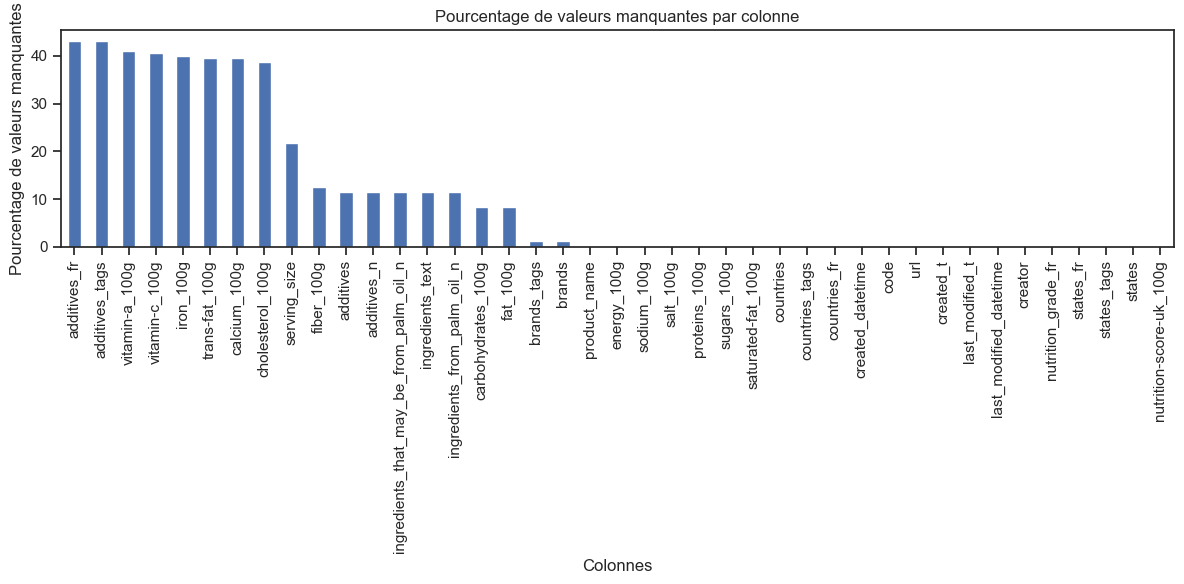

In [195]:
missing_percentages = (XClean.isnull().mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
missing_percentages.plot(kind='bar')
plt.title('Pourcentage de valeurs manquantes par colonne')
plt.xlabel('Colonnes')
plt.ylabel('Pourcentage de valeurs manquantes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#print(missing_percentages)

In [196]:
def impute_missing_values(data):
    dataImputed = data.copy()
    
    numericColumns = data.select_dtypes(include=[np.number]).columns
    for col in numericColumns:
        if col != "fiber_100g":
            dataImputed[col] = dataImputed[col].fillna(dataImputed[col].median())
        else:
            dataImputed[col] = dataImputed[col].fillna(0)
    
    return dataImputed

In [197]:
XImputed = impute_missing_values(XClean)
missing_percentages = (XImputed.isnull().mean() * 100).sort_values(ascending=False)

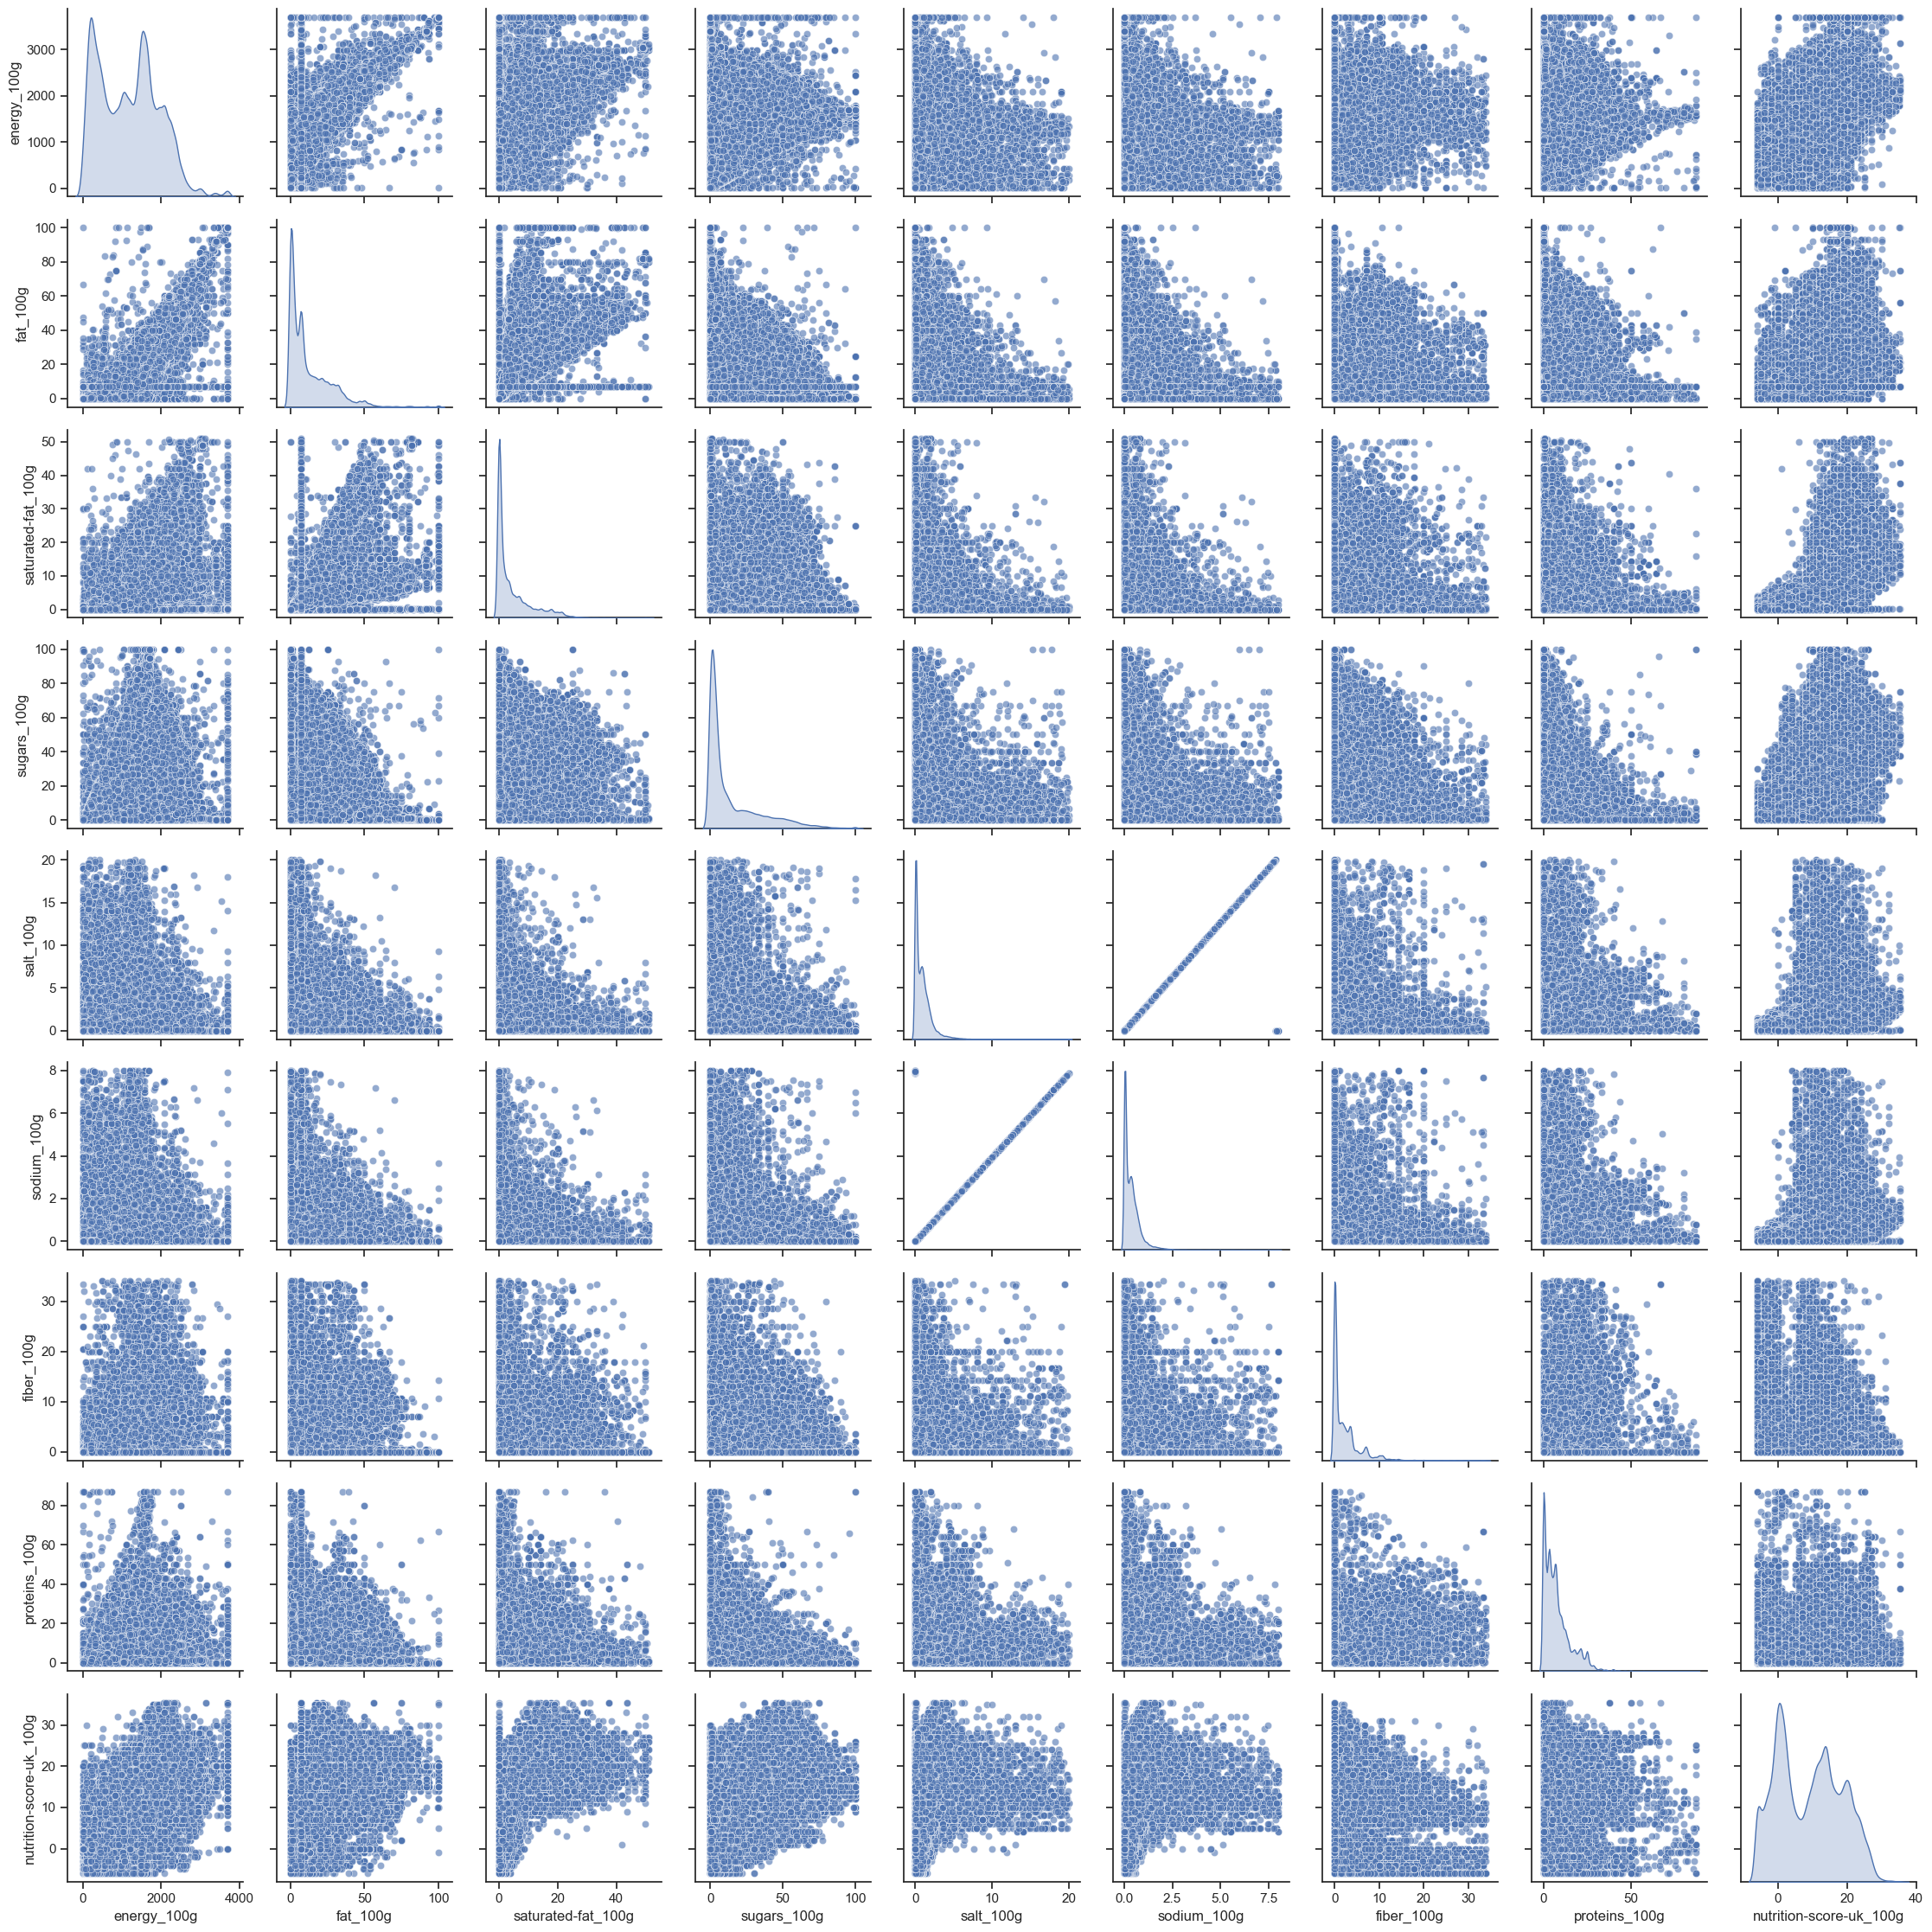

In [198]:
sns.set_theme(style="ticks")
sns.pairplot(XImputed[numericColumns], diag_kind="kde", markers="o", plot_kws={'alpha': 0.6})
plt.tight_layout()
plt.show()


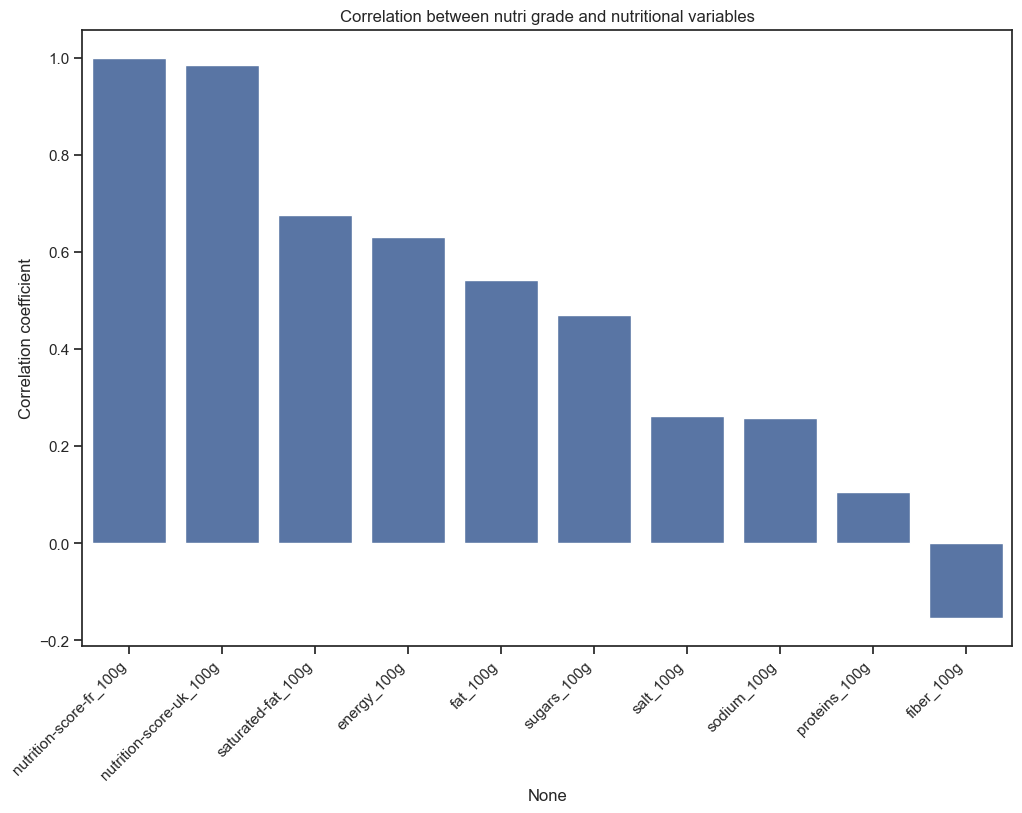

In [199]:
dataCombined = pd.concat([XImputed, y], axis=1)
correlations = dataCombined[numericColumns + [y.name]].corr()[y.name].sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Correlation between nutri grade and nutritional variables')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation coefficient')
plt.show()

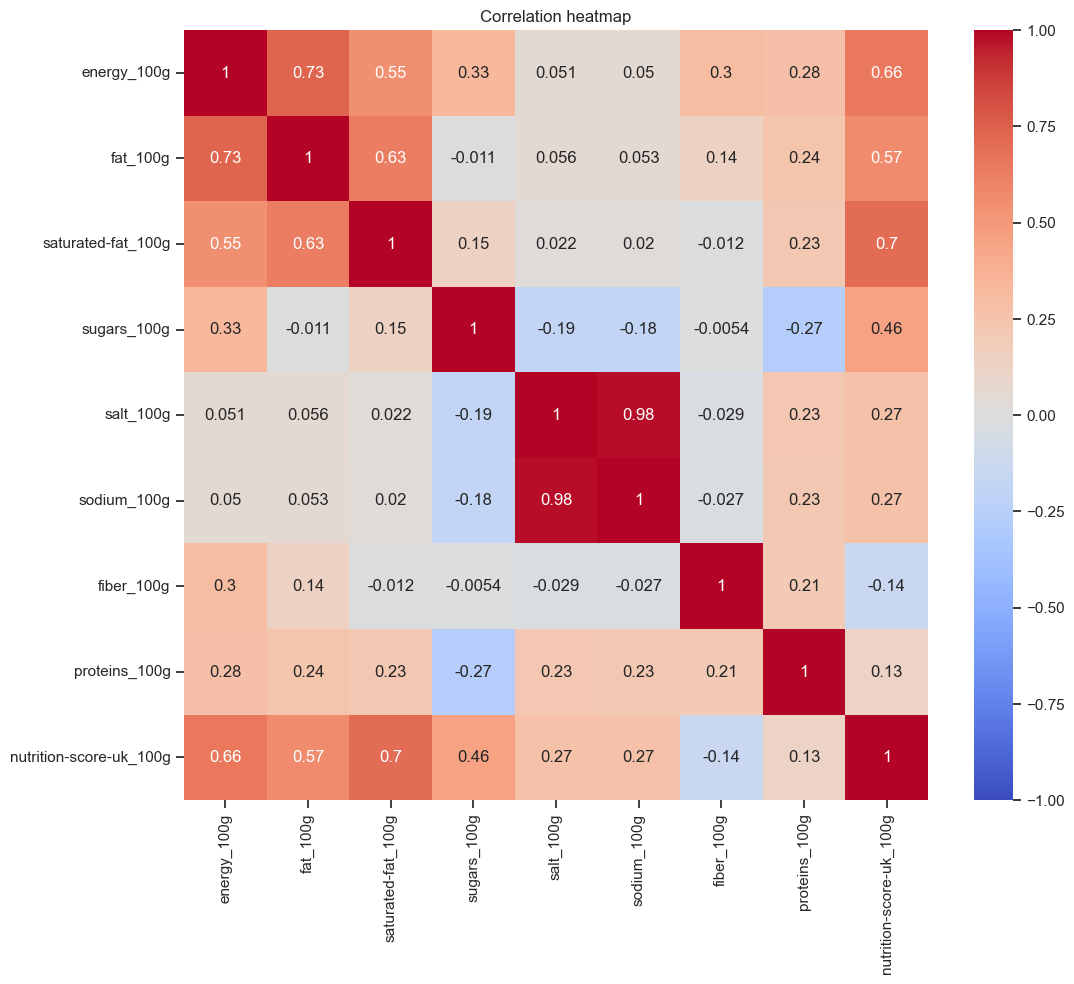

In [200]:
plt.figure(figsize=(12, 10))
sns.heatmap(dataCombined[numericColumns].corr(), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation heatmap')
plt.show()

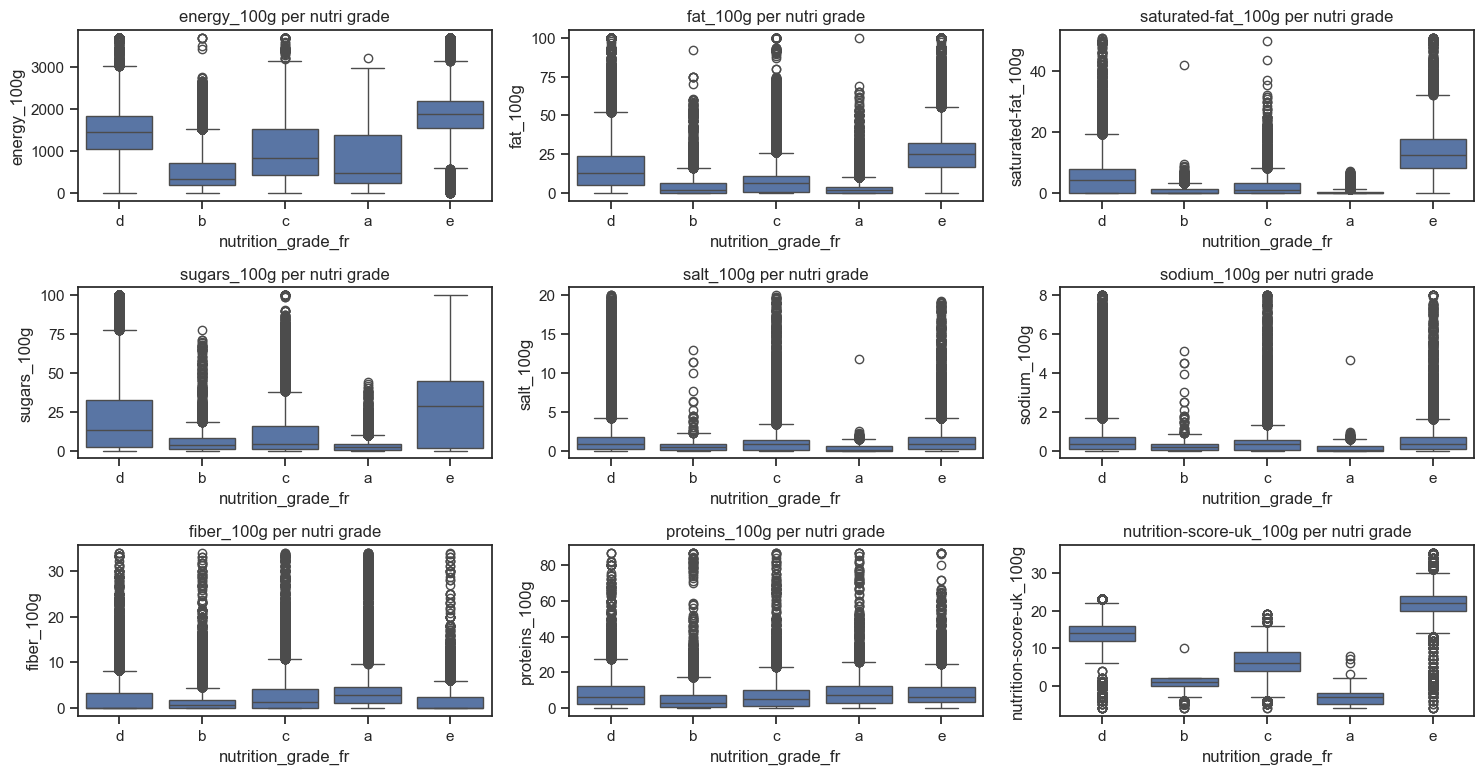

In [201]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(numericColumns, 1):
    if var in XImputed.columns:
        plt.subplot(len(numericColumns) // 3 + 1, 3, i)
        sns.boxplot(x='nutrition_grade_fr', y=var, data=pd.concat([XImputed, y], axis=1))
        plt.title(f'{var} per nutri grade')
plt.tight_layout()
plt.show()

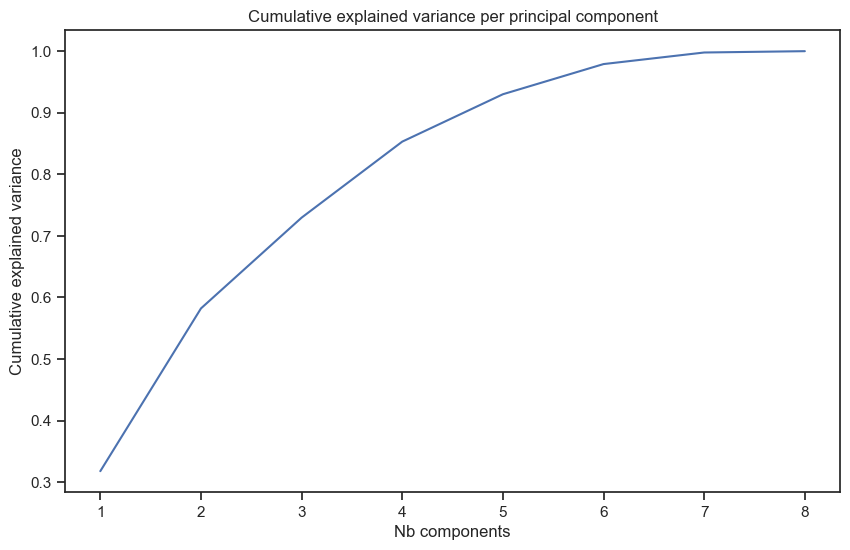

In [203]:
numericColumns.remove('nutrition-score-uk_100g')
scaler = StandardScaler()
XScaled = scaler.fit_transform(XImputed[numericColumns])

pca = PCA()
XPca = pca.fit_transform(XScaled)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nb components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance per principal component')
plt.show()

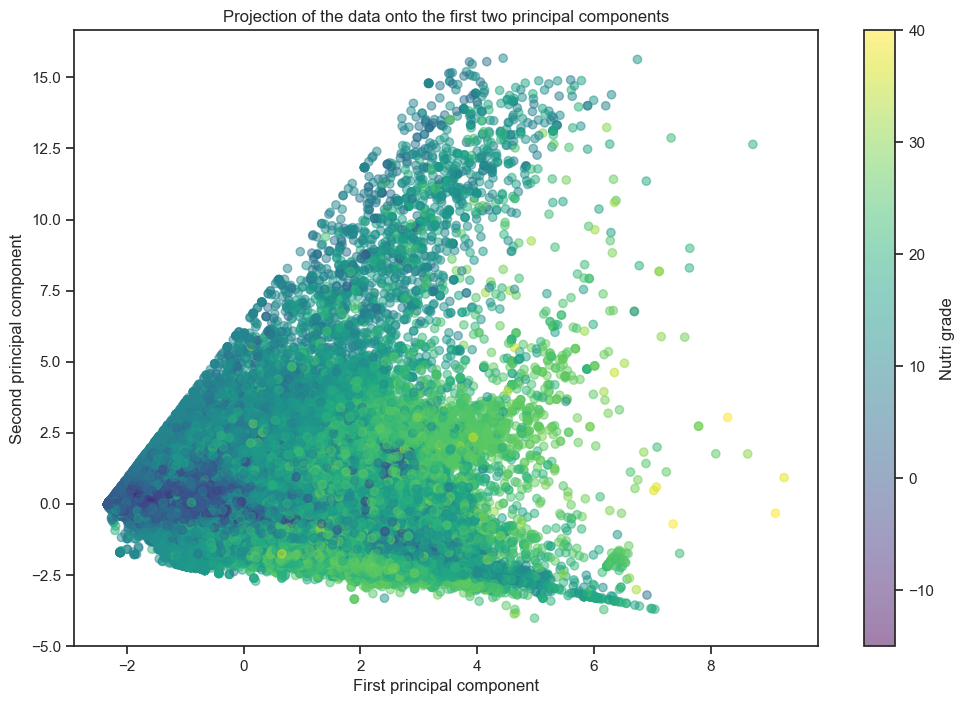

In [205]:
plt.figure(figsize=(12, 8))
plt.scatter(XPca[:, 0], XPca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of the data onto the first two principal components')
plt.colorbar(label='Nutri grade')
plt.show()

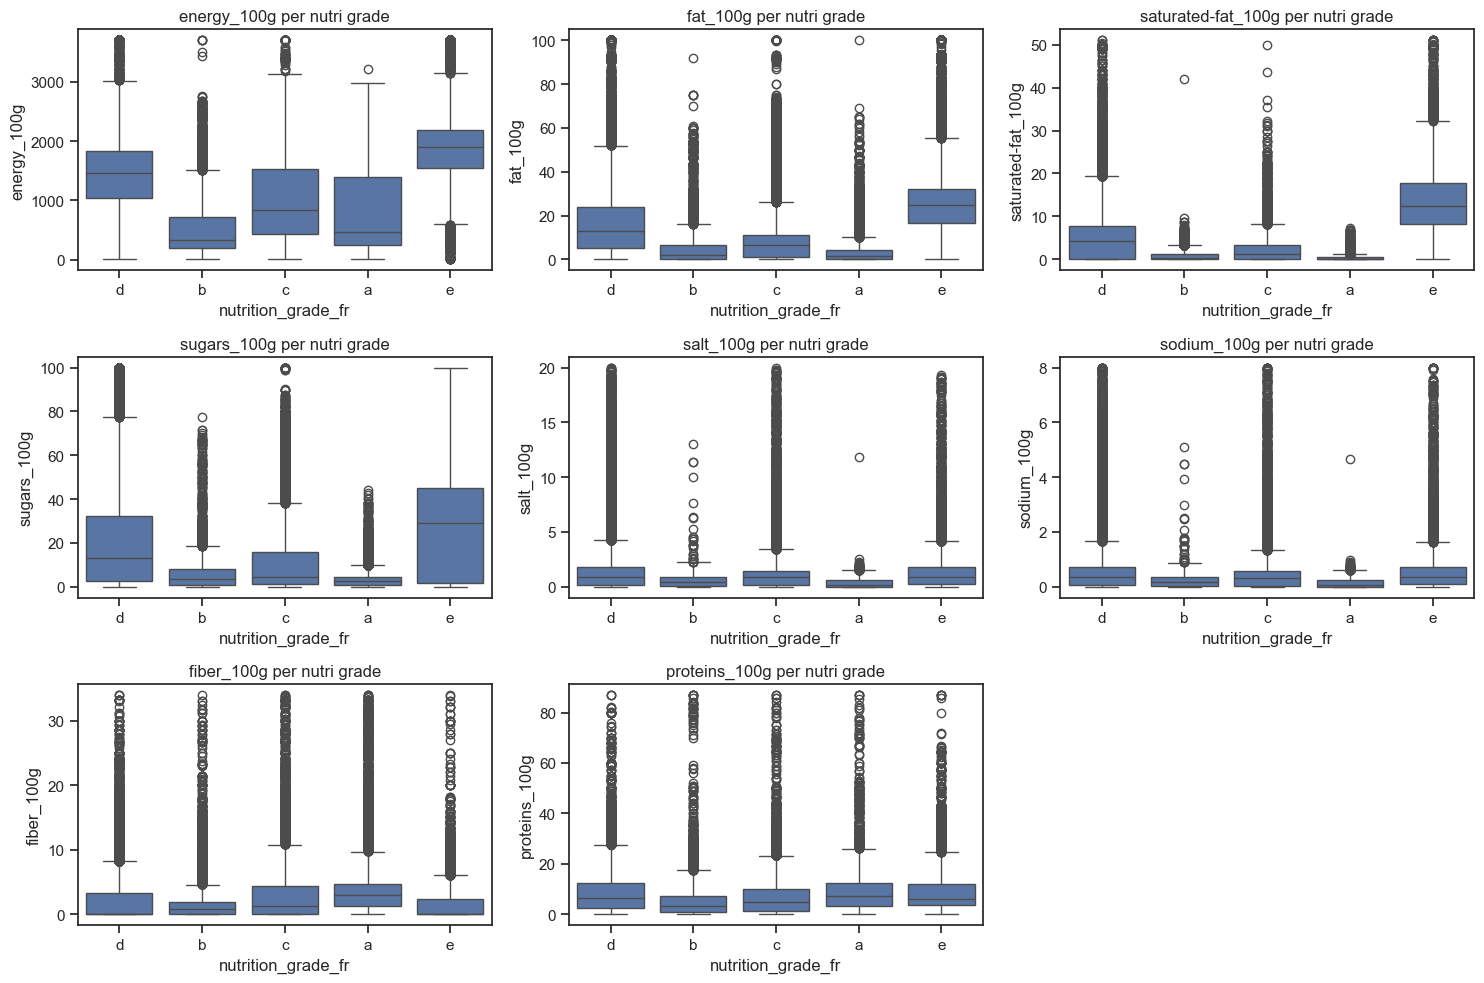

In [206]:
plt.figure(figsize=(15, 10))
for i, var in enumerate(numericColumns, 1):
    if var in XImputed.columns:
        plt.subplot(3, 3, i)
        sns.boxplot(x='nutrition_grade_fr', y=var, data=pd.concat([XImputed, y], axis=1))
        plt.title(f'{var} per nutri grade')
plt.tight_layout()
plt.show()

In [207]:
for var in numericColumns:
    if var in XImputed.columns:
        groups = [group for _, group in XImputed[var].groupby(y)]
        f_value, p_value = stats.f_oneway(*groups)
        print(f"ANOVA for {var}:")
        print(f"F-value: {f_value}")
        print(f"p-value: {p_value}")
        print("\n")

ANOVA for energy_100g:
F-value: 3448.2672856283953
p-value: 0.0


ANOVA for fat_100g:
F-value: 1763.0461911918815
p-value: 0.0


ANOVA for saturated-fat_100g:
F-value: 4393.642610168355
p-value: 0.0


ANOVA for sugars_100g:
F-value: 1382.2943698245892
p-value: 0.0


ANOVA for salt_100g:
F-value: 361.87678738694325
p-value: 0.0


ANOVA for sodium_100g:
F-value: 354.7388035806148
p-value: 0.0


ANOVA for fiber_100g:
F-value: 657.8461111483332
p-value: 0.0


ANOVA for proteins_100g:
F-value: 197.748254522884
p-value: 0.0




Les résultats suggèrent que la variable nutrition_score_fr_100g est statistiquement significative pour prédire les niveaux de différentes variables nutritionnelles. Cela peut être utile pour comprendre comment les différentes classes de nutrition_score_fr_100g sont associées à des profils nutritionnels spécifiques dans votre ensemble de données.
Nutrition_score_fr_100g avec les categorie des aliment peuvent aider a donner le nutrition_grade_fr